# 0. Library import

In [19]:
import pandas as pd
import random
import math
import numpy as np

# 1. train, test data split 

In [20]:
df=pd.read_csv('hw2_data.csv')

X=df[['x']]
y=df[['y']]

def train_test_split(X, y, train_ratio=0.8, random_seed=None):
    X_values = X.values
    y_values = y.values

    if random_seed is not None:
        np.random.seed(random_seed)

    indices = np.random.permutation(len(X_values))
    X_values = X_values[indices]
    y_values = y_values[indices]

    train_size = int(len(X_values) * train_ratio)

    train_x = np.array(X_values[:train_size])
    train_y = np.array(y_values[:train_size])

    test_x = np.array(X_values[train_size:])
    test_y = np.array(y_values[train_size:])

    return train_x, test_x, train_y, test_y

# split the train, test data in 8:2 ratio
# set the random_seed number to get static result
train_x, test_x, train_y, test_y=train_test_split(X, y, train_ratio=0.8, random_seed=10)

# 2. DenseLayer class define

In [58]:
class DenseLayer:
    def __init__(self, in_features, out_features,activation,bias=True):
        # set the layer with in_features, out_features,activation
        # in_features: input dim for layer
        # out_features: output dim for layer
        # activation : activation function that use in the layer
        
        self.in_features = in_features+1  #add 1 for bias
        self.out_features = out_features
        self.activation_function=activation
        
        #set weight for 'he' initialization
        self.weight = np.random.randn(self.in_features, self.out_features) * np.sqrt(2 / (self.in_features + self.out_features))
        
        self.gradient = np.zeros(self.in_features)
        self.input_data=np.zeros(self.in_features)
        self.node_output=np.zeros(self.out_features) 
        self.weight_sum=np.zeros(self.out_features)

        if bias:
            # Initialize bias with ones
            self.bias = np.ones((self.out_features,))
        else:
            self.bias = np.zeros((self.out_features,))
            
        # ADAM parameters
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

        # ADAM moments
        self.m = np.zeros_like(self.weight)
        self.v = np.zeros_like(self.weight)
        self.t = 0
    def forward(self, x):
        # add bias for input 
        if x.ndim == 1:  # if a single sample
            x_with_bias = np.insert(x, 0, 1)
            self.input_data = x_with_bias
        else:  # if a batch of samples
            x_with_bias = np.insert(x, 0, 1, axis=1)
            self.input_data = np.mean(x_with_bias, axis=0)

        
        #calculate the input * weight for weight sum
        result = np.dot(x_with_bias, self.weight)
        self.weight_sum = result

        #use activation function
        if self.activation_function is None:
            result_after_activation = result
        else:
            result_after_activation = self.activation_function(result)

        self.node_output = result_after_activation

        return result_after_activation

    def calculate_gradient(self, gradient):
        if gradient.ndim > 1:  # if a not single sample
            gradient=np.mean(gradient, axis=0)
        
        tmp = np.zeros(self.in_features)
        output = np.zeros(self.in_features - 1)

        if self.activation_function is None: # check output layer or not
            for i in range(self.out_features):
                tmp[:self.in_features - 1] += gradient[i] * self.input_data[:self.in_features - 1]
                output += gradient[i] * self.weight[:self.in_features - 1, i]

            self.gradient = tmp

        else:
            activation_derivative = self.activation_function.derivative(self.weight_sum)
            activation_derivative=np.mean(activation_derivative, axis=0)

            for i in range(self.out_features):
                tmp[:self.in_features - 1] += gradient[i] * activation_derivative[i] * self.input_data[:self.in_features - 1]
                output += gradient[i] * activation_derivative[i] * self.weight[:self.in_features - 1, i]

            self.gradient = tmp

        return output


    def update_weights(self, learning_rate, optimization):

        if optimization == 'sgd':
            if len(self.gradient.shape) == 1:
                self.gradient = self.gradient.reshape((-1, 1))

            self.weight -= learning_rate * self.gradient
            return 
        elif optimization == 'adam':
            if len(self.gradient.shape) == 1:
                self.gradient = self.gradient.reshape((-1, 1))
            self.t += 1
            self.m = self.beta1 * self.m + (1 - self.beta1) * self.gradient
            self.v = self.beta2 * self.v + (1 - self.beta2) * (self.gradient ** 2)
            m_hat = self.m / (1 - self.beta1 ** self.t)
            v_hat = self.v / (1 - self.beta2 ** self.t)
            self.weight -= learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
            
            self.m = self.m.reshape(self.weight.shape)
            self.v = self.v.reshape(self.weight.shape)
            return
    def __call__(self, x):
        return self.forward(x)

# 3. Activation Function

In [59]:
class ReLU:
    def __call__(self, x):
        return np.where(x > 0, x, 0.0)

    def derivative(self, x):
        return np.where(x > 0, 1.0, 0.0)
    
class LeakyReLU:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
    def __call__(self, x):
        return np.where(x >= 0, x, self.alpha * x)
    def derivative(self, x):
        return np.where(x >= 0, 1.0, self.alpha)

class Tanh:
    def __call__(self, x):
        return np.tanh(x)

    def derivative(self, x):
        tanh_x = self.__call__(x)
        return 1 - tanh_x**2

class Sigmoid:
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def derivative(self, x):
        sigmoid_x = self.__call__(x)
        return sigmoid_x * (1 - sigmoid_x)

# 4. Model define

In [60]:
class MyModel:
    def __init__(self, in_features, hidden_layer, out_features,layers,activation,optimization):
        # set the layer with in_features, out_features,activation
        # in_features: input dim for layer
        # out_features: output dim for layer
        # activation : activation function that use in the layer
        # layers : number of layers for model
        # optimization : optimization method parameter "sgd", "adam"

        self.activation_functions = {
            'sigmoid': Sigmoid(),
            'relu': ReLU(),
            'tanh': Tanh(),
            'leakyrelu':LeakyReLU()
        }

        # select the activation function 
        self.activation = self.activation_functions.get(activation.lower(), Sigmoid())
        
        self.optimization=optimization
        self.layer_list = [None] * layers
        
        # i==0 input layer , i=layers-1 output layer
        for i in range(layers):
            if i == 0:
                self.layer_list[i] = DenseLayer(in_features, hidden_layer, self.activation)
            elif i == layers - 1:
                self.layer_list[i] = DenseLayer(hidden_layer, out_features, None)
            else:
                self.layer_list[i] = DenseLayer(hidden_layer, hidden_layer, self.activation)
        for i in self.layer_list:
            print(i.in_features,i.out_features)

    
    def forward(self, x):
        for index,layer in enumerate(self.layer_list):
            if index==0:
                output = layer(x)
            else:
                output = layer(output)

        return output
    
    #backpropagation
    def backward(self,gradient): 
        temp_gradient=gradient
        for layer in reversed(self.layer_list):
            temp_gradient=layer.calculate_gradient(temp_gradient)

    def update_weights(self, learning_rate,):
        for layer in reversed(self.layer_list):
            layer.update_weights(learning_rate,self.optimization)



# 5. Loss function

In [61]:
class MSELoss:
    def __call__(self, y_pred, y):
        return 0.5 * ((y_pred - y) ** 2)
    
    def derivative(self, y_pred, y):
        return y_pred - y

# 6. Hyperparameter setting

In [105]:
def count_parameters(model):
    total_params = 0
    for layer in model.layer_list:
        total_params += np.prod(layer.weight.shape) 
        if hasattr(layer, 'bias'):
            total_params += np.prod(layer.bias.shape)  
    return total_params


in_dim = 1
hidden_dim = 150
out_dim = 1
layers=3
optimization='adam'
activation='relu'

model = MyModel(in_dim, hidden_dim, out_dim,layers,activation,optimization)
loss_function=MSELoss()
num_params = count_parameters(model)
print(f"Total number of parameters in the model: {num_params}")

2 150
151 150
151 1
Total number of parameters in the model: 23402


# 7. Train & Test

In [100]:
num_epochs = 100
lr = 0.0001
num_samples=len(train_x)
batch_size=1
early_stop_loss=0
total_train_loss = []
for epoch in range(num_epochs):

    loss_list=[]
    # Mini-batch training
    for i in range(0, num_samples, batch_size):
        x_batch = np.array(train_x[i:i + batch_size])
        y_batch = np.array(train_y[i:i + batch_size])
        # Forward pass
        y_pred_batch = model.forward(x_batch)

        loss = loss_function(y_pred_batch, y_batch)
        model.backward(loss_function.derivative(y_pred_batch, y_batch))
        model.update_weights(lr)

        loss_list.append(loss)
        total_train_loss.append(loss)

        
        
    # Validation
    total_val_loss = 0

    for i in range(test_x.shape[0]):
        x_val = test_x[i]
        y_val = test_y[i]
        
        # Forward pass for validation
        y_pred_val = model.forward(x_val)

        # Calculate validation loss
        val_loss = loss_function(y_pred_val, y_val)
        total_val_loss += val_loss

    # Calculate and print the average validation loss for this epoch
    avg_val_loss = total_val_loss / len(test_x)
    
    
    if abs(np.mean(loss_list) - early_stop_loss) <= 0.00001:
        print("early stop!!")
        break
    early_stop_loss=np.mean(loss_list)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {np.mean(loss_list)},Validation Loss: {avg_val_loss[0]}")

avg_train_loss = np.mean(total_train_loss)
print(f"Final Training Loss: {avg_train_loss}")
print(f"Final Validation Loss: {avg_val_loss[0]}")

Epoch [1/100], Training Loss: 3.433873720667958,Validation Loss: 1.1019044873870962
Epoch [2/100], Training Loss: 0.336366337987154,Validation Loss: 0.11678877636071779
Epoch [3/100], Training Loss: 0.07752567961554199,Validation Loss: 0.034803719716690544
Epoch [4/100], Training Loss: 0.028881553207677053,Validation Loss: 0.015210658107460985
Epoch [5/100], Training Loss: 0.019815290378436455,Validation Loss: 0.01197207730562145
Epoch [6/100], Training Loss: 0.01677993316306185,Validation Loss: 0.010615296235456258
Epoch [7/100], Training Loss: 0.014660212598979105,Validation Loss: 0.009825630611838363
Epoch [8/100], Training Loss: 0.013051480595243874,Validation Loss: 0.009591799184052348
Epoch [9/100], Training Loss: 0.011789641854312225,Validation Loss: 0.009651372971856016
Epoch [10/100], Training Loss: 0.01075759578995829,Validation Loss: 0.009404410140457472
Epoch [11/100], Training Loss: 0.00983434440001666,Validation Loss: 0.007939244547581615
Epoch [12/100], Training Loss: 0.

In [104]:
for indx,data in enumerate(model.layer_list):
    print(f"layer {indx}")
    print(f"weights {data.weight}")

layer 0
weights [[ 0.1438421   0.14475719  0.3626406   0.13256996  0.34022078  0.06049887
   0.19588194  0.32532184  0.06924711  0.13756714  0.38463232  0.26333082
   0.1415502   0.19026657  0.11681308  0.08901782  0.3313544   0.10264236
   0.08785616  0.21093521  0.20143789  0.34432877  0.13178213  0.01987056
   0.53307274  0.22902496  0.25084601  0.07193961  0.04812081  0.08707747
   0.07393118  0.18341079  0.04388145  0.05419496  0.07820018  0.21738468
   0.09273535  0.22626574 -0.0333951   0.26532561  0.26602777  0.22090978
  -0.09950724  0.09376205  0.13266043  0.20335159  0.24996635  0.26056922
   0.19981566  0.47488492  0.13757245  0.18844319  0.27663806  0.20626721
   0.16213124  0.39072555  0.2970409   0.04357199  0.04833884  0.22901065
   0.15629953  0.1950038   0.00424535  0.30288409  0.1871853   0.271656
   0.26997344  0.17835112  0.39309183  0.13439492  0.22311095  0.30819283
   0.19957506  0.16396976  0.28996444  0.26498237  0.13298505  0.33385444
   0.29331064  0.175341 

# 8. Graph

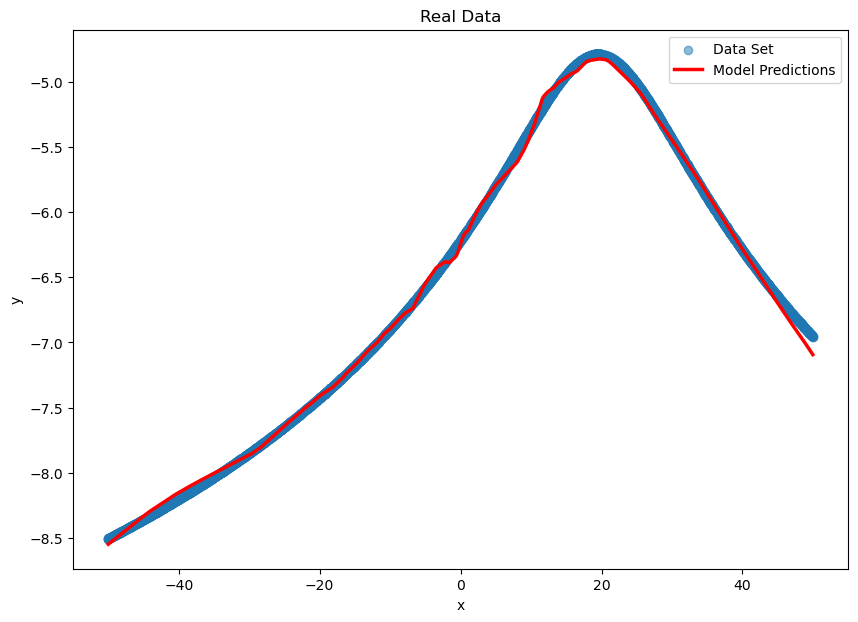

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
# Plotting the real data
plt.figure(figsize=(10, 7))
plt.title("Real Data")



data = pd.read_csv("hw2_data.csv").sort_values(by='x', axis=0)# data soting 진행
plt.scatter(data['x'], data['y'], color='tab:blue', alpha=0.5, label="Data Set")
predictions=[]
for i in data['x']:
    predictions.append(model.forward(np.array(i).reshape(-1,1)))

predictions = np.array(predictions).squeeze()
# Plotting the predictions from your model
plt.plot(data['x'], predictions, color='red', label="Model Predictions", linewidth=2.5)

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
